In [20]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
from scipy.linalg import hadamard
import scipy.signal
import pylab
from scipy.misc import derivative

# Set up helper functions

In [21]:
def set_walsh_sim(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
        of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
        = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        return walsh_func_stretch

def spectrometer(timestream, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a spectrometer for a given timestream.

    Parameters:
    - timestream: The input time-domain signal.
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated magnitude spectra.
    """
    num_samples = len(timestream)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    spectra = []
    integrated_spectra = []

    for i in range(num_segments):
        start_index = i * fft_length
        end_index = start_index + fft_length
        segment = timestream[start_index:end_index]
        
        # Perform FFT
        spectrum = np.fft.fft(segment)[:fft_length//2]
        magnitude_spectrum = np.abs(spectrum)
        spectra.append(magnitude_spectrum)
        
    spectra = np.reshape(spectra,(num_segments,-1))
    
    print(spectra.shape)
    # Integrate the spectra
    for i in range(num_segments//num_spectra_integration):
        start_index = (i)*num_spectra_integration 
        end_index = (i+1)*num_spectra_integration 
        integrated_spectra.append(np.sum(spectra[start_index:end_index],axis=1))

    return frequencies, spectra

def correlator(timestream0, timestream1, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a correlator for a given timestream.

    Parameters:
    - timestream0: The first input time-domain signal.
    - timestream1: The second input time-domain signal.   
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated correlation
    """
    num_samples = len(timestream0)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    integrated_correlations = []

    for i in range(num_segments):
        start_index = i * int(sampling_rate * num_spectra_integration)
        end_index = start_index + fft_length * num_spectra_integration
        segment0 = timestream0[start_index:end_index]
        segment1 = timestream1[start_index:end_index]
        
        # Perform FFT
        spectrum0 = np.fft.fft(segment0)[:fft_length//2]
        spectrum1 = np.fft.fft(segment1)[:fft_length//2]
        correlation = abs(spectrum0*spectrum1)
        
        # Integrate the spectra
        integrated_correlation = np.sum(np.reshape(correlation, (num_spectra_integration, -1)), axis=0)
        integrated_correlations.append(integrated_correlation)

    return frequencies, integrated_correlations

# Generate Walsh Patterns 

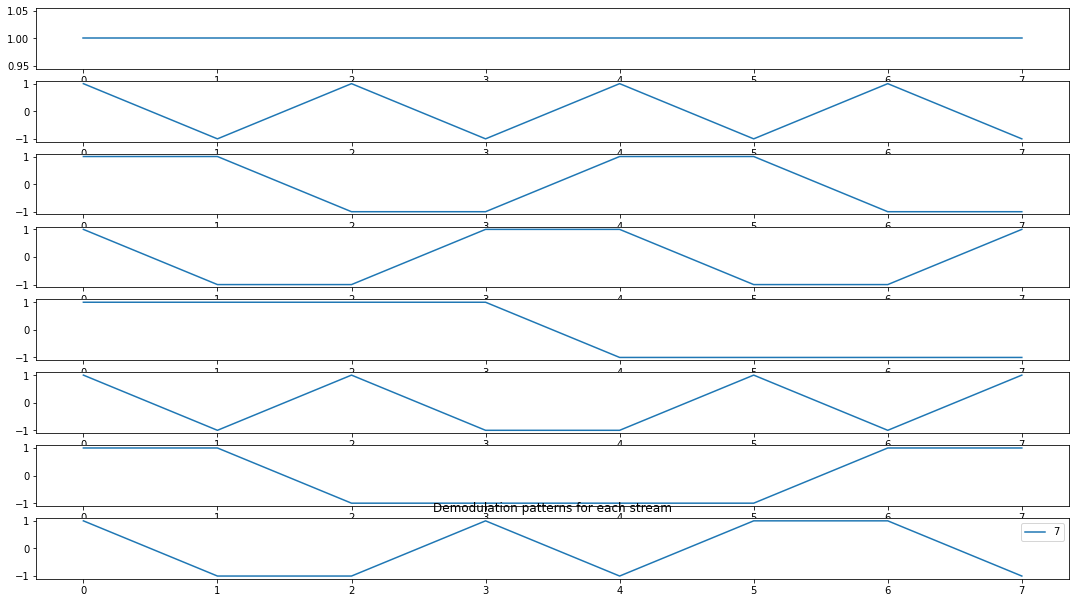

In [22]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(8,1)
fig.set_size_inches(18.5, 10.5)
for i in range(8):
    ax[i].plot(set_walsh_sim(8,i,0), label=i)
plt.title('Demodulation patterns for each stream')
plt.legend()
plt.show()

# Can we recover a signal?

In [23]:
sampling_rate = 1024  # Hz
duration = 1000  # seconds
t = np.arange(0, duration, 1/sampling_rate)
cw_signal = np.sin(2 * np.pi * 20 * t) 
cw_signal2 = np.sin(2 * np.pi * 40 * t) 

noise = np.random.normal(loc=0, scale=1, size=len(t)) 
data = noise + cw_signal

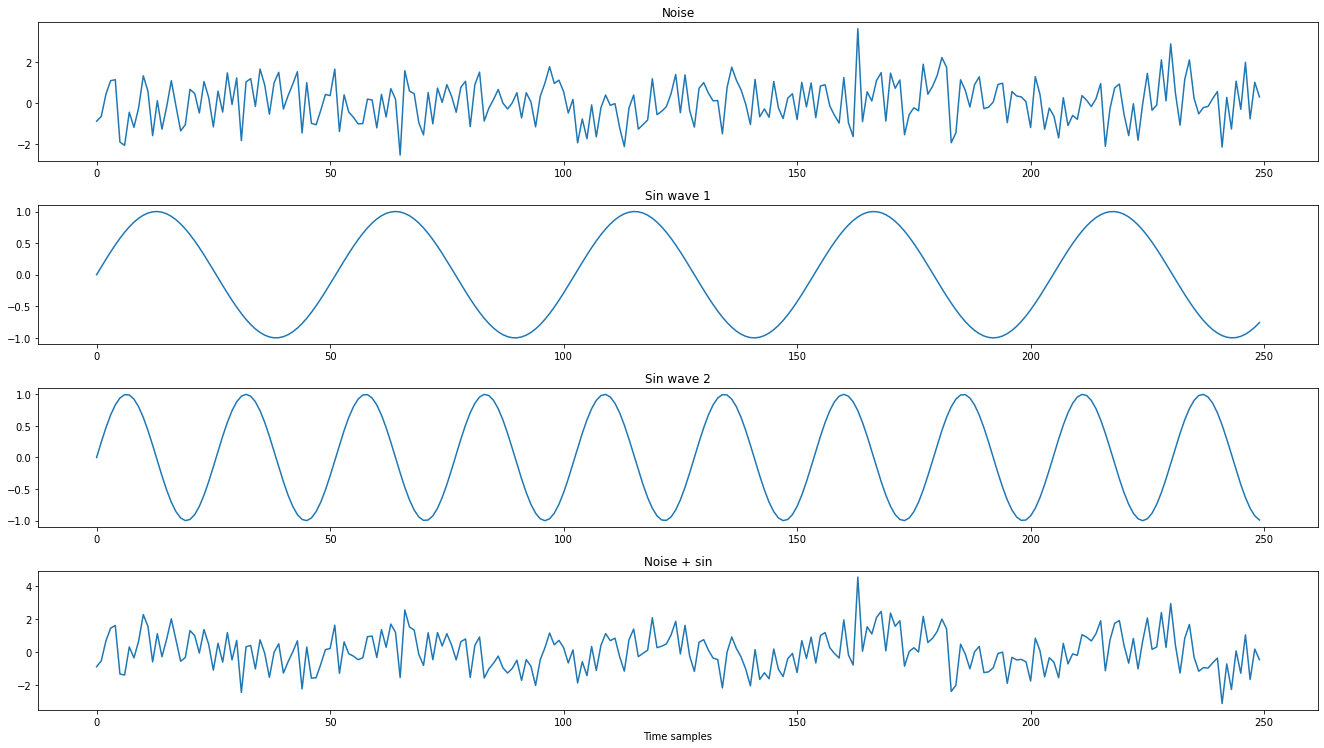

In [24]:
fig,ax = plt.subplots(4,1)
fig.set_size_inches(18.5, 10.5)

plt.subplot(4,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(4,1,2)
plt.title("Sin wave 1")
plt.plot(cw_signal[:250])
plt.subplot(4,1,3)
plt.title("Sin wave 2")
plt.plot(cw_signal2[:250])
plt.subplot(4,1,4)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

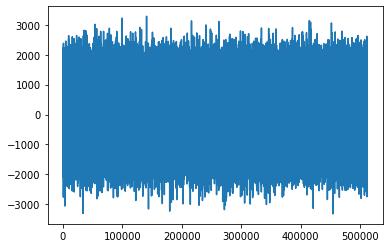

In [25]:
plt.plot(np.fft.rfft(data))

# Modulate test data stream 

In [26]:
#extend the number of samples for the walsh function to match the signal length 
period_base = len(t)//8
n= 0
n2 = period_base
walsh0 = set_walsh_sim(8,1,0)
walsh0extended = np.zeros(len(t))
for i in range(len(walsh0)):
    extended = np.array(walsh0[i].repeat(period_base))
    walsh0extended[n:n2] = extended
    n += period_base
    n2 += period_base

In [27]:
n = 0
n2 = period_base
walsh1 = set_walsh_sim(8,2,0)
walsh1extended = np.zeros(len(t))
for i in range(len(walsh1)):
    extended = np.array(walsh1[i].repeat(period_base))
    walsh1extended[n:n2] = extended
    n += period_base
    n2 += period_base

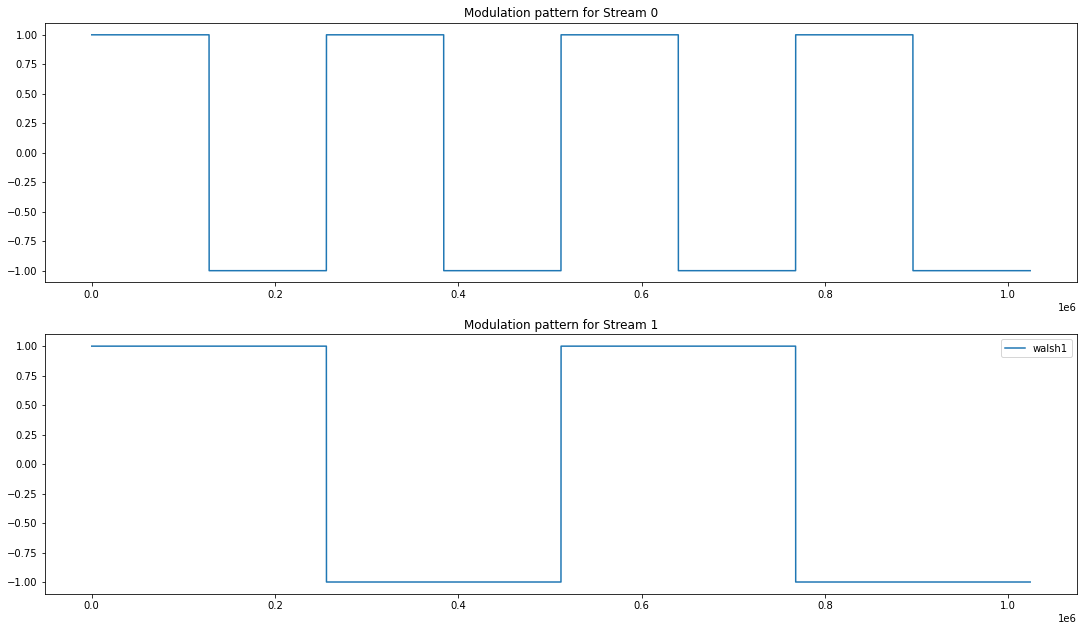

In [28]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulation pattern for Stream 0')
ax[1].set_title('Modulation pattern for Stream 1')
ax[0].plot(walsh0extended, label='walsh0')
ax[1].plot(walsh1extended, label='walsh1')
#ax[i].set_xlim(0,10)
plt.legend()
plt.show()

check orthogonality

In [29]:
np.sum(walsh0extended*walsh1extended)

0.0

In [30]:
modulated0 = np.zeros(len(walsh0extended))
modulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        modulated0[i] = data[i]
    if walsh0extended[i] == -1:
        modulated0[i] = -data[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        modulated1[i] = data[i]
    if walsh1extended[i] == -1:
        modulated1[i] = -data[i]

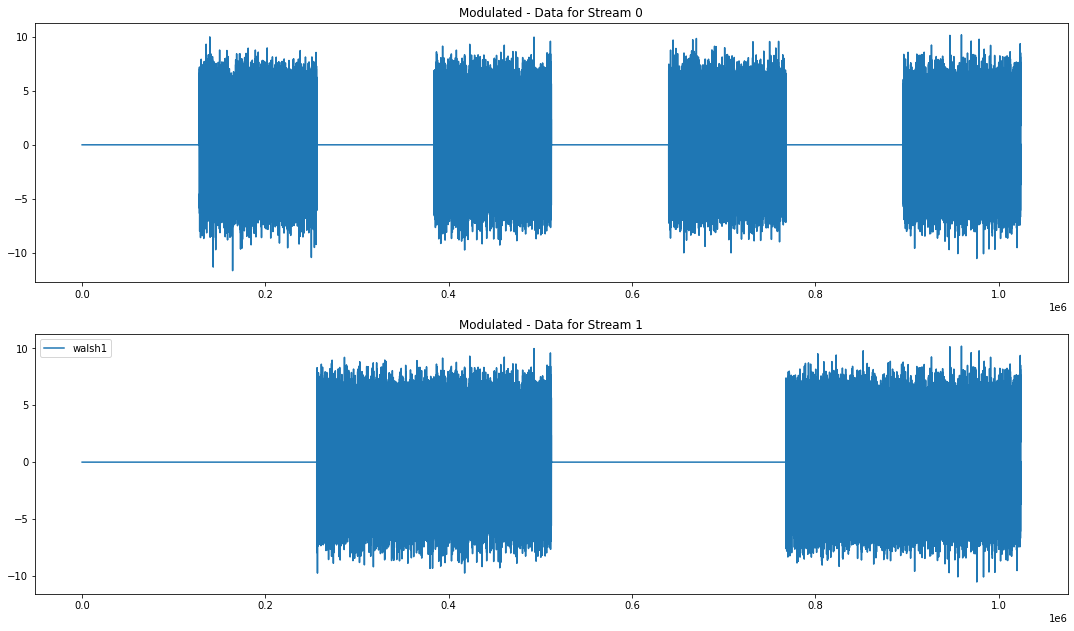

In [31]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulated - Data for Stream 0')
ax[1].set_title('Modulated - Data for Stream 1')
ax[0].plot(modulated0-data, label='walsh0')
ax[1].plot(modulated1-data, label='walsh1')
plt.legend()
plt.show()

# Demodulate

In [32]:
demodulated0 = np.zeros(len(walsh0extended))
demodulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        demodulated0[i] = modulated0[i]
    if walsh0extended[i] == -1:
        demodulated0[i] = -modulated0[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        demodulated1[i] = modulated1[i]
    if walsh1extended[i] == -1:
        demodulated1[i] = -modulated1[i]

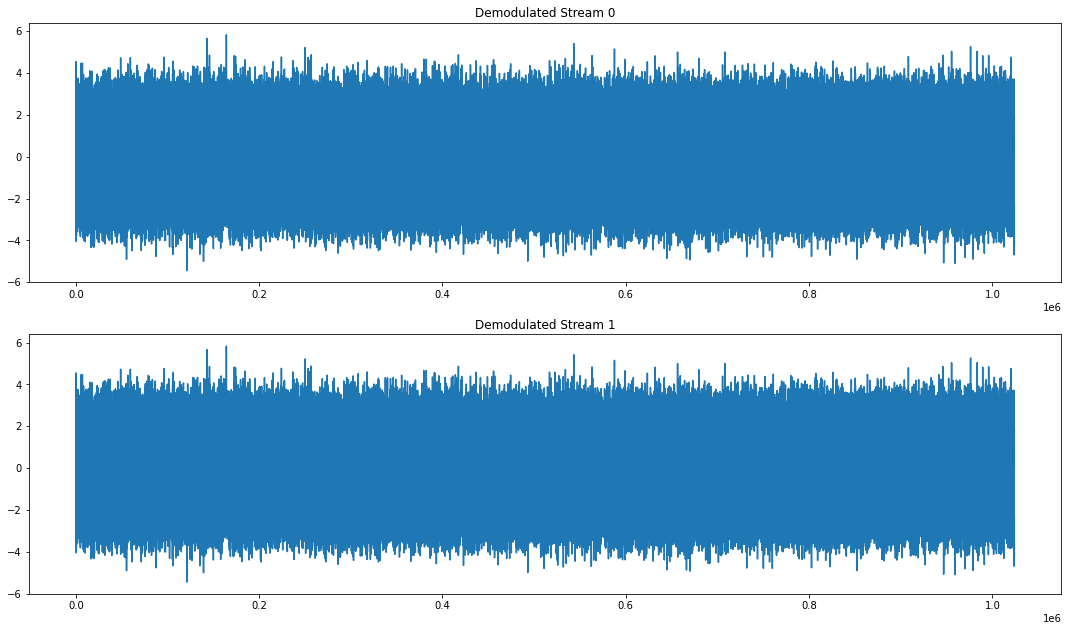

In [33]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0')
ax[1].set_title('Demodulated Stream 1')
ax[0].plot(demodulated0, label='walsh0')
ax[1].plot(demodulated1, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

do we get the same result back?

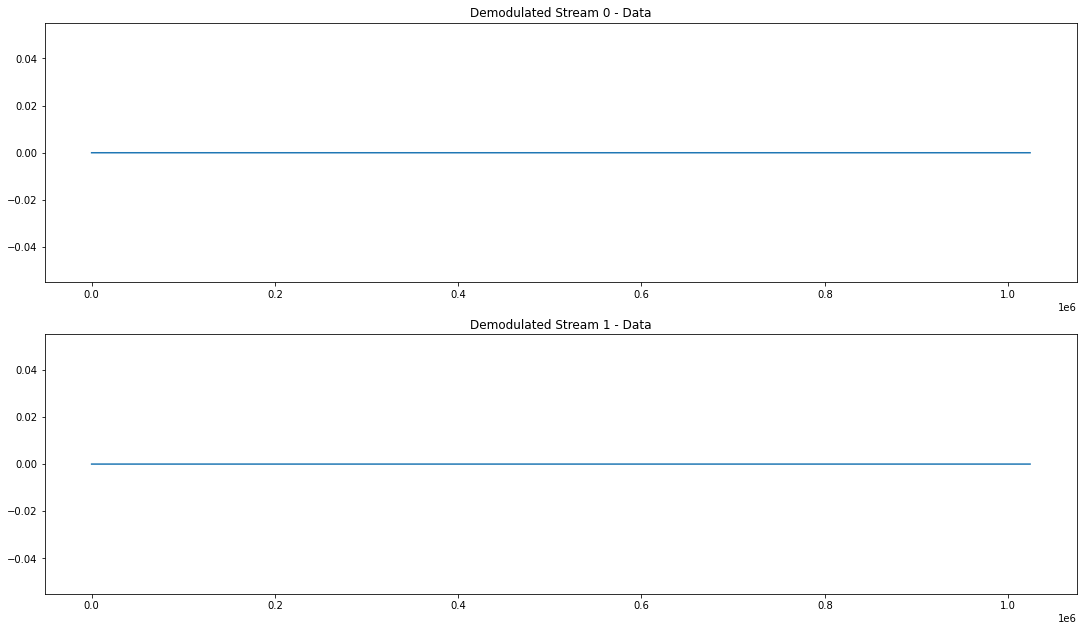

In [34]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0 - Data')
ax[1].set_title('Demodulated Stream 1 - Data')
ax[0].plot(demodulated0-data, label='walsh0')
ax[1].plot(demodulated1-data, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

# Let's try doing frequency domain now

(1000, 512)


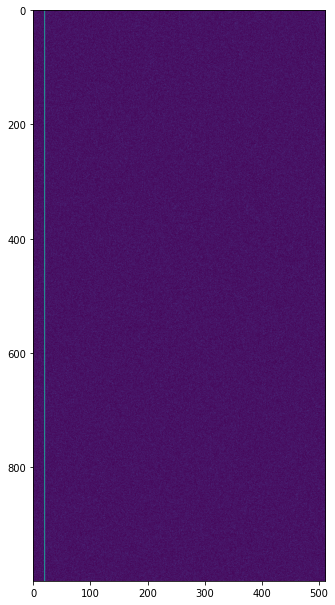

In [35]:
fft_length = 1024
num_spectra_integration = 1
fig = plt.figure()
# Create the spectrometer
frequencies, integrated_spectra = spectrometer(data, sampling_rate, fft_length, num_spectra_integration)
plt.imshow(integrated_spectra)
fig.set_size_inches(18.5, 10.5)

(100, 512)


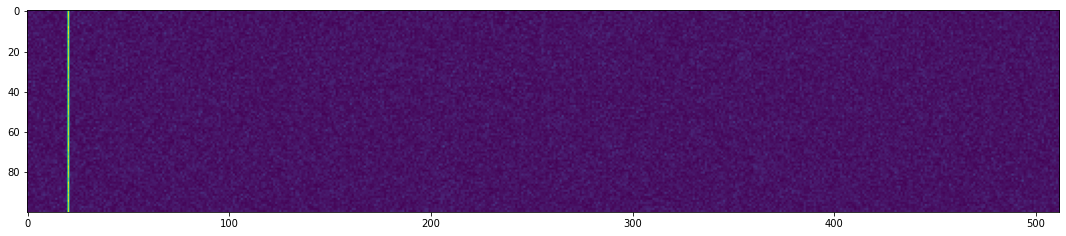

In [37]:
num_spectra_integration = 10
frequencies, integrated_spectra = spectrometer(modulated0, sampling_rate, fft_length, num_spectra_integration)
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(integrated_spectra)

# Code up Equation from Thompson

Let U(t) be an unwanted system response, and U1(t) be the mean residual spurious voltage

In [38]:
def mrsv(T,M, u_m):
   return(T**m/(2**(math.factorial(M)))*derivative(u_m))